In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from seaborn import color_palette
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, utils
import copy
from utils import *
%matplotlib inline

# CONVERT IMAGE TO TENSOR

In [2]:
def make_img_tensor(img_names, mult=1.0):
    
    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ])
    
    result_tensor = None
    for name in img_names:
        img_raw = cv2.imread(name)
        img_raw = cv2.resize(img_raw, dsize=None, fx=mult, fy=mult)
        img_tensor = image_transform (img_raw).unsqueeze(0)
        if result_tensor is None:
            result_tensor = img_tensor
        else:
            # size of each template image must be same
            result_tensor = torch.cat([result_tensor, img_tensor], dim=0)
    return result_tensor

In [3]:
image = make_img_tensor(['sample/sample1.jpg'])
image_raw = cv2.imread('sample/sample1.jpg')

In [4]:
# template images must have same size
template_list = ['template/template1_1.png', 'template/template1_2.png', 'template/template1_dummy.png']
template = make_img_tensor(template_list)

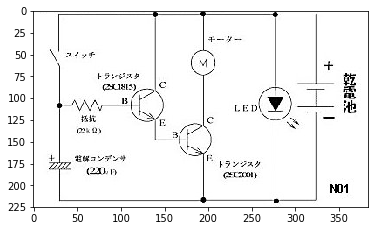

In [5]:
plt.imshow(image_raw)

# EXTRACT FEATURE

In [6]:
class Featex():
    def __init__(self, model, use_cuda):
        self.use_cuda = use_cuda
        self.feature1 = None
        self.feature2 = None
        self.model= copy.deepcopy(model.eval())
        self.model = self.model[:17]
        for param in self.model.parameters():
            param.requires_grad = False
        if self.use_cuda:
            self.model = self.model.cuda()
        self.model[2].register_forward_hook(self.save_feature1)
        self.model[16].register_forward_hook(self.save_feature2)
        
    def save_feature1(self, module, input, output):
        self.feature1 = output.detach()
    
    def save_feature2(self, module, input, output):
        self.feature2 = output.detach()
        
    def __call__(self, input, mode='big'):
        if self.use_cuda:
            input = input.cuda()
        _ = self.model(input)
        if mode=='big':
            # resize feature1 to the same size of feature2
            self.feature1 = F.interpolate(self.feature1, size=(self.feature2.size()[2], self.feature2.size()[3]), mode='bilinear', align_corners=True)
        else:        
            # resize feature2 to the same size of feature1
            self.feature2 = F.interpolate(self.feature2, size=(self.feature1.size()[2], self.feature1.size()[3]), mode='bilinear', align_corners=True)
        return torch.cat((self.feature1, self.feature2), dim=1)

In [7]:
class MyNormLayer():
    def __call__(self, x1, x2):
        bs, _ , H, W = x1.size()
        _, _, h, w = x2.size()
        x1 = x1.view(bs, -1, H*W)
        x2 = x2.view(bs, -1, h*w)
        concat = torch.cat((x1, x2), dim=2)
        x_mean = torch.mean(concat, dim=2, keepdim=True)
        x_std = torch.std(concat, dim=2, keepdim=True)
        x1 = (x1 - x_mean) / x_std
        x2 = (x2 - x_mean) / x_std
        x1 = x1.view(bs, -1, H, W)
        x2 = x2.view(bs, -1, h, w)
        return [x1, x2]

In [19]:
class CreateModel():
    def __init__(self, alpha, model, use_cuda):
        self.alpha = alpha
        self.featex = Featex(model, use_cuda)
    def __call__(self, template, image):
        T_feat = self.featex(template)
        I_feat = self.featex(image)
        conf_maps = None
        batchsize_T = T_feat.size()[0]
        for i in range(batchsize_T):
            T_feat_i = T_feat[i].unsqueeze(0)
            I_feat_norm, T_feat_i = MyNormLayer()(I_feat, T_feat_i)
            dist = torch.einsum("xcab,xcde->xabde", I_feat_norm / torch.norm(I_feat_norm, dim=1, keepdim=True), T_feat_i / torch.norm(T_feat_i, dim=1, keepdim=True))
            conf_map = QATM(self.alpha)(dist)
            if conf_maps is None:
                conf_maps = conf_map
            else:
                conf_maps = torch.cat([conf_maps, conf_map], dim=0)
        return conf_maps

In [20]:
class QATM():
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, x):
        batch_size, ref_row, ref_col, qry_row, qry_col = x.size()
        x = x.view(batch_size, ref_row*ref_col, qry_row*qry_col)
        xm_ref = x - torch.max(x, dim=1, keepdim=True)[0]
        xm_qry = x - torch.max(x, dim=2, keepdim=True)[0]
        confidence = torch.sqrt(F.softmax(self.alpha*xm_ref, dim=1) * F.softmax(self.alpha * xm_qry, dim=2))
        conf_values, ind3 = torch.topk(confidence, 1)
        ind1, ind2 = torch.meshgrid(torch.arange(batch_size), torch.arange(ref_row*ref_col))
        ind1 = ind1.flatten()
        ind2 = ind2.flatten()
        ind3 = ind3.flatten()
        if x.is_cuda:
            ind1 = ind1.cuda()
            ind2 = ind2.cuda()
        
        values = confidence[ind1, ind2, ind3]
        values = torch.reshape(values, [batch_size, ref_row, ref_col, 1])
        return values
    def compute_output_shape( self, input_shape ):
        bs, H, W, _, _ = input_shape
        return (bs, H, W, 1)

# NMS AND PLOT

## SINGLE

In [21]:
def nms(score, w_ini, h_ini, thresh=0.7):
    dots = np.array(np.where(score > thresh*score.max()))
    
    x1 = dots[1] - w_ini//2
    x2 = x1 + w_ini
    y1 = dots[0] - h_ini//2
    y2 = y1 + h_ini

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    scores = score[dots[0], dots[1]]
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= 0.5)[0]
        order = order[inds + 1]
    boxes = np.array([[x1[keep], y1[keep]], [x2[keep], y2[keep]]]).transpose(2, 0, 1)
    return boxes

In [22]:
def plot_result(image_raw, boxes, show=False, save_name=None, color=(255, 0, 0)):
    # plot result
    d_img = image_raw.copy()
    for box in boxes:
        d_img = cv2.rectangle(d_img, tuple(box[0]), tuple(box[1]), color, 3)
    if show:
        plt.imshow(d_img)
    if save_name:
        cv2.imwrite(save_name, d_img[:,:,::-1])
    return d_img

## MULTI

In [23]:
def nms_multi(scores, w_ini, h_ini, thresh=0.7):
    indices = np.arange(scores.shape[0])
    maxes = np.max(scores.reshape(scores.shape[0], -1), axis=1)
    # omit not-matching templates
    scores = scores[maxes > 0.2 * maxes.max()]
    indices = indices[maxes > 0.2 * maxes.max()]
    
    # extract candidate pixels from scores
    dots = None
    dos_indices = None
    for index, score in zip(indices, scores):
        dot = np.array(np.where(score > thresh*score.max()))
        if dots is None:
            dots = dot
            dots_indices = np.ones(dot.shape[-1]) * index
        else:
            dots = np.concatenate([dots, dot], axis=1)
            dots_indices = np.concatenate([dots_indices, np.ones(dot.shape[-1]) * index], axis=0)
    dots_indices = dots_indices.astype(np.int)

    x1 = dots[1] - w_ini//2
    x2 = x1 + w_ini
    y1 = dots[0] - h_ini//2
    y2 = y1 + h_ini

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    scores = scores[dots_indices, dots[0], dots[1]]
    order = scores.argsort()[::-1]
    dots_indices = dots_indices[order]
    
    keep = []
    keep_index = []
    while order.size > 0:
        i = order[0]
        index = dots_indices[0]
        keep.append(i)
        keep_index.append(index)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= 0.1)[0]
        order = order[inds + 1]
        dots_indices = dots_indices[inds + 1]
        
    boxes = np.array([[x1[keep], y1[keep]], [x2[keep], y2[keep]]]).transpose(2,0,1)
    return boxes, np.array(keep_index)

In [24]:
def plot_result_multi(image_raw, boxes, indices, show=False, save_name=None, color_list=None):
    d_img = image_raw.copy()
    if color_list is None:
        color_list = color_palette("hls", len(np.unique(indices)))
        color_list = list(map(lambda x: (int(x[0]*255), int(x[1]*255), int(x[2]*255)), color_list))
    for i in range(len(indices)):
        d_img = plot_result(d_img, boxes[i][None, :,:].copy(), color=color_list[indices[i]])
    if show:
        plt.imshow(d_img)
    if save_name:
        cv2.imwrite(save_name, d_img[:,:,::-1])
    return d_img

# RUNNING

In [25]:
def run_one_sample(template, image):
    val = model(template, image)
    if val.is_cuda:
        val = val.cpu()
    val = val.numpy()
    val = np.log(val)
    
    batch_size = val.shape[0]
    scores = []
    for i in range(batch_size):
        # compute geometry average on score map
        gray = val[i,:,:,0]
        gray = cv2.resize( gray, (image.size()[-1], image.size()[-2]) )
        h = template.size()[-2]
        w = template.size()[-1]
        score = compute_score( gray, w, h) 
        score[score>-1e-7] = score.min()
        score = np.exp(score / (h*w)) # reverse number range back after computing geometry average
        scores.append(score)
    return np.array(scores)

In [26]:
model = CreateModel(model=models.vgg19(pretrained=True).features, alpha=25, use_cuda=True)

In [27]:
scores = run_one_sample(template, image)

In [30]:
boxes, indices = nms_multi(scores, template.size()[-1], template.size()[-2], thresh=0.8)

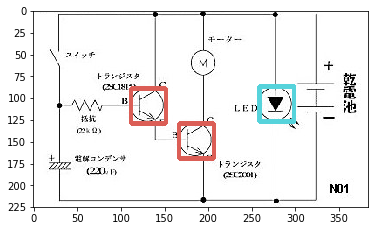

In [31]:
d_img = plot_result_multi(image_raw, boxes, indices, show=True, save_name='result_sample.png')

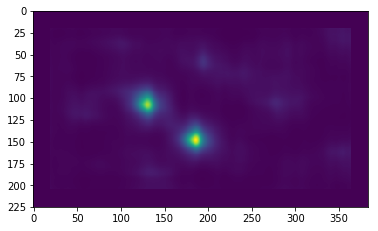

In [238]:
plt.imshow(scores[0])